# Trial simulation computational practical

<hr style="border:1px solid gray">



### The Problem
The trials I will simulate is investigating the impact of some treatment $T$ on the survival rate of a deadly disease. We will analyze our trial data using logistic regression, which means modelling the probability of death as a logistic function of $T$

$$ P(D=1|T) = \left[1+\exp\left(-\beta_0 - \beta_1 T\right)\right]^{-1}, $$

where $D=1,0$ denotes death/survival and $T=1,0$ denotes treatment/no treatment. With this form of the probability the odds of death, defined as the ratio of death probability to survival probability, are given by

$$ \text{Odds}(D=1|T) = \frac{P(D=1|T)}{P(D=0|T)} = \exp\left(\beta_0 + \beta_1 T\right).$$

The odds ratio between the treated and untreated groups is then the exponential of the regression coefficient of $T$

$$ OR = \frac{\text{Odds}(D=1|T=1)}{\text{Odds}(D=1|T=0)} = \exp\left(\beta_1\right).$$

The OR - in principle - tells us the average effect of the treatment in the sample. If the treatment improves each patient's chance of survival then we should find $OR < 1$, while $OR=1$ indicates no treatment effect, and $OR>1$ indicates that the treatment worsens survival odds. To see if our OR is statistically significant compared to one, we will compare the p-value of the regression estimate $\hat{\beta}_1$ to some significance threshold $\alpha$ (conventionally $\alpha=0.05$).

The steps of each simulated trial will be as follows:
1. Generate simulated trial data
2. Analyze the data using logistic regression
3. Extract $\hat{\beta}_1$, and its p-value and confidence interval, from the regression
4. Determine if the trial was a success ($OR < 1$ and $p < \alpha$)

### Package import
First, we import any packages we might need.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 

### Global variables
Here is where I will set parameters common to all our simulations.

In [2]:
nPatients = 1000 # Number of patients in each trial

controlDeathProb = 0.5 # Probability of mortality with no treatment
treatmentRelativeRisk = 0.75 # Factor by which treatment reduces your probability of death
treatmentDeathProb = controlDeathProb*treatmentRelativeRisk # Probability of death with treatment

nSims = 1000 # Number of times we will simulate each trial
statSigThreshold = 0.05 # statistical significance threshold for p values and confidence intervals

It's also worth here looking at the true odds ratio to compare estimates later on.

In [33]:
controlDeathOdds = controlDeathProb/(1-controlDeathProb)
treatmentDeathOdds = treatmentDeathProb/(1-treatmentDeathProb)
trueOddsRatio = treatmentDeathOdds/controlDeathOdds
print('True odds ratio =',trueOddsRatio)

True odds ratio = 0.6


### Regression function
This function will compute logistic regression, and return the odds ratio, p value, and confidence interval of the first coefficient after the intercept.

In [3]:
def myLogisticRegression(x,y,confIntThreshold = statSigThreshold):
    xWithIntercept = sm.add_constant(x)
    regression = sm.Logit(y,xWithIntercept).fit(disp=0)
    
    oddsRatio = np.exp(regression.params[1])
    
    # statsmodels calculates a two-sided p value, whereas we want a one-sided one.
    # The quick and dirty way to correct this is to just divide by 2!
    pValue = regression.pvalues[1]/2.
    lowerCI, upperCI = np.exp(regression.conf_int(confIntThreshold)[1])
    
    return oddsRatio, pValue, lowerCI, upperCI

### Trial success function
This function will compute the success of simulated trials given their odds ratios and p-values, according to some statistical significance threshold. It will then display the number of successful and unsuccessful trials and plot them on a bar chart.

In [4]:
def determineSuccess(oddsRatio, pValue, pValThreshold = statSigThreshold, display = True):
    success = ((oddsRatio < 1) & (pValue < pValThreshold)).astype(int)
    
    if display:
        successCounts = pd.Series(success).value_counts()
        successCounts.index = successCounts.index.map({0: 'Failure', 1: 'Success'})
        print(successCounts)
        successCounts.plot(kind="barh")
    return success

<hr style="border:1px solid gray">

## Simulating an RCT
First, we will simulate a bunch of randomised controlled trials (RCTs). We'll start by initializing a dataframe with `nSims` rows which will store the odds ratio, p-value, and $95$% confidence interval of each trial, as well as whether that trial was a success.

In [36]:
RCTs = pd.DataFrame(
    columns=['OR','pVal','LCI','UCI','success'],
    index = range(nSims)
)
# OR = Odds ratio of death between treatment and control groups
# pVal = p value for odds ratio
# success =  Did the trial measure a positive, statistically significant treatment effect?
# [LCI, UCI] = 95% confidence interval for odds ratio

Now we initialize numpy's random number generator, and run the simulations. Setting the seed to a definite value means we will get the same sequence of simulations every time. If you want to keep re-running the for-loop and get a new set of results every time then set the seed to `None`.

Success    985
Failure     15
dtype: int64


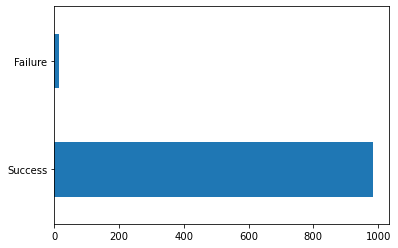

In [37]:
seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):

    treatment = np.tile([0,1],int(0.5*nPatients))
    
    deathProb = np.full(nPatients, controlDeathProb)
    deathProb[treatment==1] = treatmentDeathProb
    deathOutcome = rng.binomial(1, deathProb)

    RCTs.loc[i,['OR','pVal','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)

RCTs.success = determineSuccess(RCTs.OR, RCTs.pVal, statSigThreshold)

A vast majority of our trials are successes, so our studies have enough statistical power to measure a treatment effect of this size.
### With a covariate: patient age
I am going to add in patient age as a covariate that affects their outcome. First I will choose a random distribution for this variable, and for simplicity I will use a uniform distribution. In this code I will implement this with the line `age = rng.uniform(minAge,maxAge,nPatients)` so lets first set these minimum and maximum age variables.

In [38]:
minAge = 18
maxAge = 80

Now I need to decide how age is going to impact mortality. As a very basic example, let's assume the fatality of this disease suddenly increases above a certain age, `ageDeathThreshold`. This means I'll need the following variables.

In [39]:
ageDeathThreshold = 28
youngDeathProb = 0.1
oldDeathProb = 0.5

Now i will make a new dataframe and re-initialize the RNG, then run new simulated RCTs with outcome now dependent on age.

Success    960
Failure     40
dtype: int64


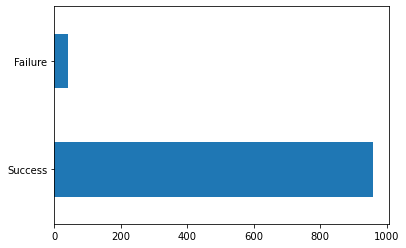

In [40]:
RCTsCov = pd.DataFrame(
    columns=['OR','pVal','LCI','UCI','success'],
    index = range(nSims)
)

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):

    treatment = np.tile([0,1],int(0.5*nPatients))

    age = rng.uniform(minAge, maxAge, nPatients)
        
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)

    RCTsCov.loc[i,['OR','pVal','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)

RCTsCov.success = determineSuccess(RCTsCov.OR, RCTsCov.pVal, statSigThreshold)

There is  a lot more failed trials but the overall success rate is still very good.

<hr style="border:1px solid gray">

## Simulating an observational study
Let's see what happens when treatment isn't completely randomized and instead depends on age, as it likely would in an observational study. This will introduce confounding bias since age is going to affect both outcome and treatment status, leading to correlations between the two.

We are going to look at a very simple scenario where treatment is only given to people above a certain age, and it is randomly assigned to half of these patients. For an extra simplification I am going to make this minimum treatment age equal to the death threshold age.

In [48]:
minAge = 18
maxAge = 80
ageDeathThreshold = 28
youngDeathProb = 0.05
oldDeathProb = 0.6

minTreatmentAge = ageDeathThreshold

Now lets re-initialize then run our observational simulations.

In [ ]:
ObsTrials = pd.DataFrame(
    columns=['OR','pVal','LCI','UCI','success'],
    index = range(nSims)
)

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):
    
    treatment = np.tile([0,1],int(0.5*nPatients))
    
    age = rng.uniform(minAge,maxAge,nPatients)

    treatment[age < minTreatmentAge] = 0
    
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)

    ObsTrials.loc[i,['OR','pVal','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)
    
ObsTrials.success = determineSuccess(ObsTrials.OR, ObsTrials.pVal, statSigThreshold)

We almost exclusively have failed trials! Why is this? Let's look at the odds ratios from these regressions.

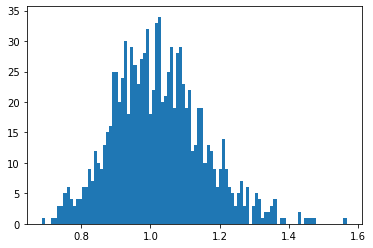

In [50]:
counts, binEdges, patches =  plt.hist(ObsTrials.OR, bins = 100)

Lots of the odds ratios are greater than one, suggesting a negative treatment effect. The reason we are seeing this is because in the observational data treatment is negatively correlated with survival. Essentially, the logistic regression models are learning that in this "real" healthcare scenario treatment predicts death - not because the treatment kills people but because the patients receiving the treatment are the ones that have a higher chance of dying.

### Including the covariate in the model
The solution to this problem is somewhat obvious: we should exclude patients younger than `minTreatmentAge` from the observational sample. This kind of restricted inclusion criteria is often used in practice (e.g., including only non-smokers in a study), although it limits sample size and makes results only applicable to the restricted population. However, imagine we don't know none of our younger patients are receiving the treatment, but we do suspect age to be a confounding variable. One way we might try to improve our analysis is to include age as another independent variable $A$ in our logistic regression model, as follows
$$ P(D=1|T,A) = \left[1+\exp\left(-\beta_0 - \beta_1 T + \beta_2 A\right)\right]^{-1}.$$
Let's rerun our observational simulations using this multivaraite logistic model and see if there's any improvement.

Failure    528
Success    472
dtype: int64


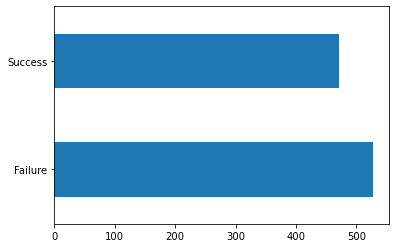

In [51]:
ObsTrialsCov = pd.DataFrame(columns=['OR','pVal','LCI','UCI','success'], index = range(nSims))

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):
    
    treatment = np.tile([0,1],int(0.5*nPatients))
    
    age = rng.uniform(minAge,maxAge,nPatients)

    treatment[age < minTreatmentAge] = 0
    
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)
    
    inputs = np.transpose([treatment,age])
    ObsTrialsCov.loc[i,['OR','pVal','LCI','UCI']] = myLogisticRegression(inputs, deathOutcome)
    
ObsTrialsCov.success = determineSuccess(ObsTrialsCov.OR, ObsTrialsCov.pVal, statSigThreshold)

This is a big improvement on the previous observational results, but still much worse than the RCTs, and still mostly failures.